# QTM151 Final Project – Section 1
## Predictive Power of Qualifying Position on Final Race Outcomes: Mercedes vs Red Bull
**Team Members:** Shourya Soni, Jack Chapon, and Xiyue Yuan


## Introduction

Formula 1 is the pinnacle of international single-seater auto racing, with drivers competing in a series of Grand Prix events around the world. Before each race, drivers participate in a timed qualifying session to determine their starting grid positions; on race day, they compete over a set distance to claim final finishing orders. In this project, we investigate whether a driver’s qualifying position can significantly predict their final race position—and whether this relationship holds consistently for two of the sport’s dominant teams, Mercedes and Red Bull. Our goal is to shed light on the extent to which early performance (qualifying) translates into race success, and to discuss potential factors that might strengthen or weaken that link.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import tabulate as tb


## Data Overview

The data for this project comes from three CSV files:
- **Qualifying**: contains one row per driver per Grand Prix qualifying session, with four columns (`raceId`, `driverId`, `constructorId`, `position`).
- **Results**: contains one row per driver per Grand Prix race, with four columns (`raceId`, `driverId`, `constructorId`, `positionOrder`).
- **Constructors**: provides team details, sorted by `constructorId`, with two columns (`constructorId`, `name`).

The table below shows each datset with its respective rows and columns:


| Dataset      | Rows   | Columns |
|--------------|--------|---------|
| Qualifying   | 9,575  | 4       |
| Results      | 25,840 | 4       |
| Constructors | 211    | 2       |

*Table 1: Dataset summary showing number of rows and columns after initial cleaning.*


In [2]:
qualifying = pd.read_csv('data_raw/qualifying.csv', usecols=['raceId', 'driverId', 'constructorId', 'position'])
results = pd.read_csv('data_raw/results.csv', usecols=['raceId', 'driverId', 'constructorId', 'positionOrder'])
constructors = pd.read_csv('data_raw/constructors.csv', usecols=['constructorId', 'name'])


datasets = {
    'Qualifying': qualifying,
    'Results': results,
    'Constructors': constructors
}

for name, df in datasets.items():
    print(name)
    print(df.info())

for name, df in datasets.items():
    print(name)
    print(df.head())

for name, df in datasets.items():
    print(name, "rows and columns:", df.shape)


Qualifying
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9575 entries, 0 to 9574
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   raceId         9575 non-null   int64
 1   driverId       9575 non-null   int64
 2   constructorId  9575 non-null   int64
 3   position       9575 non-null   int64
dtypes: int64(4)
memory usage: 299.3 KB
None
Results
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25840 entries, 0 to 25839
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   raceId         25840 non-null  int64
 1   driverId       25840 non-null  int64
 2   constructorId  25840 non-null  int64
 3   positionOrder  25840 non-null  int64
dtypes: int64(4)
memory usage: 807.6 KB
None
Constructors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------  

## Data Cleaning and Merging

After cleaning individual datasets, we merge them on their shared variables. This ensures that for each driver in a race, we have both qualifying and final position data linked to the correct constructor.

Following merging, we subset the dataset to only retain rows where the constructor is either **Mercedes** or **Red Bull** to line up with our research questions. This ensures we exclusively analyze the intended teams and prevent analysis of other teams that may skew the data, especiallly because Mercedes and Red Bull tend to be front-field teams that have higher scoring performances than teams such as Williams or Haas.

This step allows us to have a consistent analysis for regression and ensure all the values are integers so we can conduct numerical operations and make plots in the later steps. 

In [3]:
qualifying = qualifying.rename(columns = {'position': 'qualifying_position'})
results = results.rename(columns = {'positionOrder': 'final_position'})
constructors = constructors.rename(columns = {'name': 'constructor_name'})

qualifying = qualifying.dropna()
results = results.dropna()

qualifying["qualifying_position"] = qualifying["qualifying_position"].astype(int)
results["final_position"] = results["final_position"].astype(int)

merged = pd.merge(qualifying, results, on=["raceId", "driverId", "constructorId"])
merged = pd.merge(merged, constructors, on="constructorId")

merged = merged.query("constructor_name == 'Mercedes' or constructor_name == 'Red Bull'")
display(merged)
mercedes_merge = merged.query("constructor_name == 'Mercedes'")
redbull_merge = merged.query("constructor_name == 'Red Bull'")

grouped = merged.groupby(["constructor_name", 
                          "qualifying_position"])["final_position"].mean().reset_index()
mercedes = grouped.query("constructor_name == 'Mercedes'")
redbull = grouped.query("constructor_name == 'Red Bull'")


,raceId,driverId,constructorId,qualifying_position,final_position,constructor_name
7,18,14,9,8,14,Red Bull
14,18,17,9,15,17,Red Bull
29,19,17,9,8,7,Red Bull
33,19,14,9,12,9,Red Bull
54,20,17,9,11,7,Red Bull
...,...,...,...,...,...,...
9533,1095,815,9,9,7,Red Bull
9545,1096,830,9,1,1,Red Bull
9546,1096,815,9,2,3,Red Bull
9549,1096,1,131,5,18,Mercedes


##  Dataset Summary


| Dataset      | Records | Fields | Field Names & Types |
|--------------|---------|--------|---------------------|
| **Qualifying**   | 9,575   | 4      | `raceId` (**int64**), `driverId` (**int64**), `constructorId` (**int64**), `position` (**int64**) |
| **Results**      | 25,840  | 4      | `raceId` (**int64**), `driverId` (**int64**), `constructorId` (**int64**), `positionOrder` (**int64**) |
| **Constructors** | 211     | 2      | `constructorId` (**int64**), `name` (**object**) |

*Table 2: Dataset fields, types, and record counts after initial inspection.*



In [4]:
print("Rows:", len(merged))
print("Columns:", merged.shape[1])

print(merged[['qualifying_position', 'final_position']].describe())


Rows: 1211
Columns: 6
       qualifying_position  final_position
count          1211.000000     1211.000000
mean              5.587944        6.820809
std               4.633277        6.206776
min               1.000000        1.000000
25%               2.000000        2.000000
50%               4.000000        4.000000
75%               8.000000        9.000000
max              23.000000       24.000000


## Merged Dataset Summary

After merging and filtering, the final dataset contains **1211 rows** and **6 columns**.

Descriptive statistics for qualifying and final:
- **Qualifying Position**
  - Mean: 5.59
  - Standard Deviation: 4.63
  - Min: 1 (Pole Position)
  - Max: 23 (Near last grid slot)

- **Final Position**
  - Mean: 6.82
  - Standard Deviation: 6.21
  - Min: 1 (Race Win)
  - Max: 24 (Last place or DNF)

Observations:
- Drivers typically start and finish within the top 7 positions, indicating the strength of these teams in comparison to their rivals.
- However, a significant amount of variability exists (6+ grid movements on averageduring the race), implying that uncontrollable factors such as incidents, pit strategies, and weather can affect race outcomes even for top qualifiers in a race weekend. 



## Subsetting by Constructor

We divide the merged dataset into two subsets to make regression easier:
- **Mercedes dataset**
- **Red Bull dataset**

This allows us to perform separate analyses for each team, compare their consistency, and estimate whether one team translates qualifying advantage into final results more effectively than the other.

By treating teams separately, we account for different strategies, pit crews, and car performances that might influence race outcomes.  There are internal and external factors for why car performance varies, but that cannot be analyzed with the data at hand, so this analysis is for all positions no matter of the situation.


## Descriptive Statistics by Team

We compute the mean and standard deviation of qualifying and final positions separately for each constructor.


In [5]:
mean_q_m = mercedes_merge["qualifying_position"].mean()
std_q_m = mercedes_merge["qualifying_position"].std()
mean_f_m = mercedes_merge["final_position"].mean()
std_f_m = mercedes_merge["final_position"].std()

mean_q_r = redbull_merge["qualifying_position"].mean()
std_q_r = redbull_merge["qualifying_position"].std()
mean_f_r = redbull_merge["final_position"].mean()
std_f_r = redbull_merge["final_position"].std()

print("Mercedes Qualifying Mean and Std:", mean_q_m, std_q_m)
print("Mercedes Final Mean and Std:", mean_f_m, std_f_m)
print("Red Bull Qualifying Mean and Std:", mean_q_r, std_q_r)
print("Red Bull Final Mean and Std:", mean_f_r, std_f_r)


Mercedes Qualifying Mean and Std: 4.433268858800774 4.056516380660525
Mercedes Final Mean and Std: 5.71953578336557 5.847601490777042
Red Bull Qualifying Mean and Std: 6.448126801152738 4.847104216486915
Red Bull Final Mean and Std: 7.641210374639769 6.342288199120275



For Mercedes:
- Average qualifying position: 4.4
- Average final position: 5.7

For Red Bull:
- Average qualifying position: 6.4
- Average final position: 7.6

Interpretation:
- We expect both teams to have relatively low (better) qualifying and final positions.
- Both teams also have similiar standard deviations in th race and in qualifying. 

This summary allows us to see the 'closeness' of the relationship between qualifying and the race for both teams. It indicates that Mercedes overall has a lower average qualifying and final position compared to Redbull, highlighting the superior performance of Mercedes throughout Formula 1. Another detail to note is that Red Bull has more race data overall, showing that they have been in the sport longer than Mercedes.  


## Average Final Position by Qualifying Position (Using a For Loop)

We group the data by constructor and qualifying position and calculate the mean final position for each qualifying spot.

In order to do this, we created a list called "f1_table" where we iterated through every qualifying
position and associated it with the average finishing position of both Mercedes and Red Bull based
on their qualifying position.  These values are rounded to 2 decimal places.  The list is then converted to a dataframe before it is formatted and printed using **tabulate**.

For tabulate, we researched different ways to format tables, and after discovering tabulate, we used the link below to learn how to create our table:
http://geeksforgeeks.org/introduction-to-python-tabulate-library/


In [6]:
f1_table = []
for i in range(1, 23):
    mercedes_avg = grouped.query("constructor_name == 'Mercedes' and qualifying_position == @i")["final_position"]
    redbull_avg = grouped.query("constructor_name == 'Red Bull' and qualifying_position == @i")["final_position"]
    if not mercedes_avg.empty and not redbull_avg.empty:
        f1_table.append({"Qualifying Position": i,
                       "Mercedes Average Final": round(mercedes_avg.values[0], 2),
                       "Red Bull Average Final": round(redbull_avg.values[0], 2)})
f1_table_data = pd.DataFrame(f1_table)

print(tb.tabulate(f1_table_data, headers='keys', tablefmt='fancy_grid', colalign=("center", "center", "center"), showindex=False))


╒═══════════════════════╤══════════════════════════╤══════════════════════════╕
│  Qualifying Position  │  Mercedes Average Final  │  Red Bull Average Final  │
╞═══════════════════════╪══════════════════════════╪══════════════════════════╡
│           1           │           3.12           │           2.86           │
├───────────────────────┼──────────────────────────┼──────────────────────────┤
│           2           │           3.86           │           5.28           │
├───────────────────────┼──────────────────────────┼──────────────────────────┤
│           3           │           5.25           │           5.44           │
├───────────────────────┼──────────────────────────┼──────────────────────────┤
│           4           │           5.18           │           6.6            │
├───────────────────────┼──────────────────────────┼──────────────────────────┤
│           5           │           6.97           │           8.06           │
├───────────────────────┼───────────────

Observations:
- For the top qualifying spots (P1 – P4), both teams generally finish near the front, reflecting strong race pace.
- For lower qualifying spots (P13+), final results vary widely.  For Mercedes, position P18 and before, the finishing position is closer to the middle or back, but for P20 - P22, the finishing position averages are higher.  This is likely due to the fact that Mercedes have been a dominant team for a long time, so when they qualify at the back, it is due to an unforseen circumstance liek engine failure, tire blowup, or large penalties.  Is does not reflect their car performance as they are much faster on race day.  Red Bull does not follow this same pattern.  

## Regression Analysis

We fit OLS models to predict final race results based on qualifying positions separately for Mercedes and Red Bull.


In [7]:
model_m = smf.ols(formula = 'final_position ~ qualifying_position', data = mercedes)
results_m = model_m.fit()
b_m = results_m.params

mercedes = mercedes.copy()

mercedes["m1"] = b_m.iloc[0] + b_m.iloc[1] * mercedes["qualifying_position"]

print("Mercedes regression coefficients:")
print(b_m)




Mercedes regression coefficients:
Intercept              6.637063
qualifying_position    0.158402
dtype: float64


In [8]:
model_r = smf.ols(formula = 'final_position ~ qualifying_position', data = redbull)
results_r = model_r.fit()
b_r = results_r.params

redbull = redbull.copy()

redbull["m2"] = b_r.iloc[0] + b_r.iloc[1] * redbull["qualifying_position"]

print("Red Bull regression coefficients:")
print(b_r)



Red Bull regression coefficients:
Intercept              4.630096
qualifying_position    0.484546
dtype: float64


## Regression Line Plot

We visualize the estimated regression lines predicting final race position based on qualifying position for each constructor.


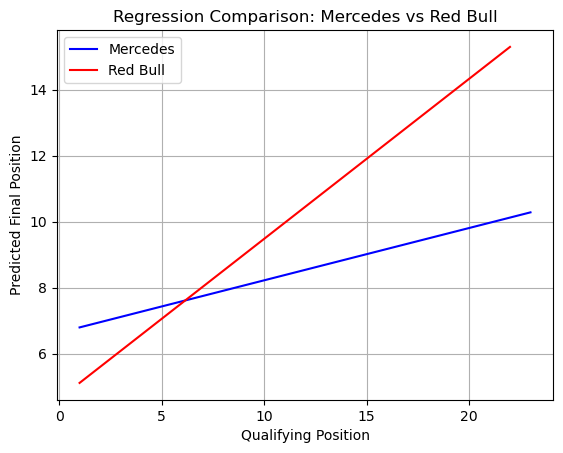

In [9]:
plt.plot(mercedes["qualifying_position"], mercedes["m1"], label="Mercedes", color="blue")
plt.plot(redbull["qualifying_position"], redbull["m2"], label="Red Bull", color="red")
plt.xlabel("Qualifying Position")
plt.ylabel("Predicted Final Position")
plt.title("Regression Comparison: Mercedes vs Red Bull")
plt.legend()
plt.grid(True)
plt.show()


## Regression Line Plot

In the plot titled "Regression Comparison: Mercedes vs Red Bull", used the OLS model to visualise the relationship between qualifying performance and race performance for both teams:

- **Mercedes**  has a flatter slope, indicating that changes in qualifying position have a smaller impact on the predicted final race position compared to Red Bull.
- **Red Bull**  has a steeper slope, meaning that when Red Bull drivers qualify further back, their final race results worsen more significantly than Mercedes drivers.
- The intercept for Red Bull is lower, implying that when starting near the front (P1–P3), Red Bull has very strong race results, but their performance declines more rapidly for poor qualifying spots compared to Mercedes.

Interpretation:
- **Mercedes** shows stronger race day resilience: even if Mercedes drivers start further down the grid, their final position does not deteriorate as much as Red Bull drivers.
- **Red Bull** depends more heavily on strong qualifying: poor starting positions are much more costly for them on race day while strong qualifying positions translate to very strong results.  
- This aligns with historical race observations where Mercedes often recovers better through strategy, pit stops, or driver consistency.

 Note:
- This simple linear model captures a meaningful performance trend.
- However, real race outcomes are influenced by complex dynamics not modeled here (e.g., safety cars, mechanical reliability, overtaking ease).  As races are longer than qualifying, there is more time for errors and issues, so there is room for variety, as shown by the analysis.  

Overall, this simplified regression model shows the slight edge that Mercedes holds over Red Bull when it comes to qualifying and finishing better in a race.


## Grouped Average Final Position Plot

We visualize average final positions by qualifying spot for each constructor using markers.


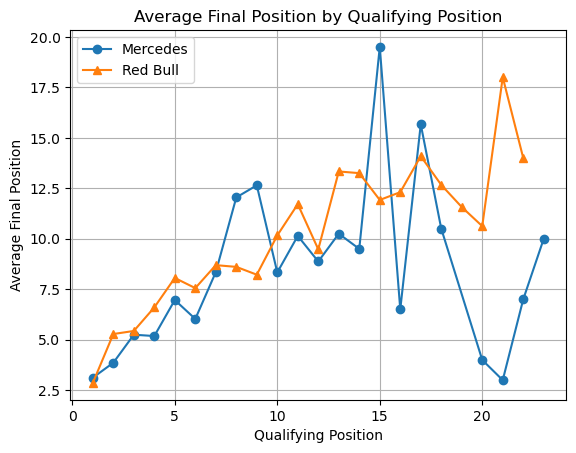

In [10]:
plt.plot(mercedes['qualifying_position'], mercedes['final_position'], label='Mercedes', marker = 'o')
plt.plot(redbull['qualifying_position'], redbull['final_position'], label='Red Bull', marker = '^')
plt.title('Average Final Position by Qualifying Position')
plt.xlabel('Qualifying Position')
plt.ylabel('Average Final Position')
plt.legend()
plt.grid(True)
plt.show()



The second plot, "Average Final Position by Qualifying Position", shows the average final finishing position grouped by each qualifying position (1 through 22):

- **Mercedes**  shows a slightly more stable and lower average final position for most qualifying spots compared to Red Bull.
- Mercedes' curve fluctuates a little more, indicating that Mercedes drivers do suffer from inconsistency in certain qualifying positions.  However, they are generally below Red Bull (Orange) across most of the positions, showing stronger performance per position started as a whole.  
- Red Bull’s average final position rises more sharply for poor qualifying spots, suggesting that Red Bull struggles more when not starting near the front.  They are a little more consistent, but the overall trend shows less strong perfomance than Mercedes.  

Key Observations:
- From positions 1–5, both teams achieve excellent final results, often winning or finishing in podium positions.
- For qualifying positions greater than 10, Mercedes drivers generally outperform Red Bull drivers in average finishing position.
- Mercedes occasionally achieves strong race recoveries even from mid-grid starting positions, seen by sharp dips in final position at places like P15 and P19.  For P20+, Mercedes shows very strong finishing positions, implying that there was an external factor which explains their poor performance on qualifying day but strong performance on race day.  

The grouped averages supports validation of the regression findings: the relationship between qualifying and final position is real and meaningful, but Mercedes shows stronger race-day resilience across the grid.


## Final Discussion

Overall, the analysis confirms a strong, positive relationship between qualifying and final race positions for both Mercedes and Red Bull. However, several important differences emerge:

- Race Day Consistency:  
  - Mercedes drivers, even when qualifying mid-grid, tend to finish stronger than Red Bull drivers.
  - Red Bull’s performance is more dependent on starting at the front: when qualifying poorly, their final positions drop more steeply.

- Visual Confirmation:  
  - The regression line for Mercedes lies consistently lower than Red Bull’s across most qualifying positions, confirming that, holding starting place constant, Mercedes typically finishes higher.
  - Grouped averages further reveal that Mercedes maintains lower (better) final positions across a wider range of starting spots.

- Racecraft and Strategy Factors:  
  - The stronger resilience shown by Mercedes may reflect better pit stop strategies, superior car reliability, or more effective in-race decision-making compared to Red Bull.  From a technical POV, Mercedes are known to build cars that perform better on race-day, meaning that their qualifying position doesn't truly reflect their full advantage.  

Limitations:
- Only qualifying and final positions were modeled. Other race factors (e.g., penalties, weather conditions, crashes) could refine the model further.  Races are longer distance (1.5 - 3 hours), so any number of things can impact a driver's final position.
- Sample includes multiple seasons, possibly mixing eras of different team dominance and rules (22 drivers being present in some races while there are currently only 20)

To build upon this, our regression model could be more advanced and include more data such as the weather, tyre types, or engine types to make our predictions more accurate

Conclusion:
- For both high-performance teams, starting towards the front yields a competitive advantages over the rest of the field, however, mercedes has been better at maximising their performances and finishing stronger regardless of where they started while Red Bull tends to require a good qualifying session to finish better in the race. This indicates a more race-tailored car by mercedes and shows their overall consistency compared  to Red Bull. 
